# Pearson Family Zones — tutorial notebook

This notebook mirrors `examples/scripts/pearson_family_demo.py` but uses fixed, editable
parameters (no argparse). It classifies Pearson families directly from central moments
→ $(\beta_1, \beta_2)$ using `pygsk.thresholds` helpers and renders the zones in the
(\(N\cdot d\) vs. \(M\)) plane.


In [1]:
# --- Parameters (edit here) ---
Mmin, Mmax = 2, 256
Ndmin, Ndmax = 0.5, 128.0
d = 1.0          # degrees-of-freedom correction
eps = 1e-9       # boundary tolerance in classification
resM, resNd = 128, 128
FIGDIR = "_figs"
PNG_OUT = f"{FIGDIR}/nb_pearson_zones.png"

import os, numpy as np
os.makedirs(FIGDIR, exist_ok=True)


In [2]:
# --- Imports ---
import matplotlib.pyplot as plt
from pygsk.thresholds import (
    sk_moments_central,
    beta_invariants_from_central,
    classify_pearson_beta,
)


In [3]:
# --- Compute zone classification grid ---
Ms = np.linspace(Mmin, Mmax, resM)
Nds = np.linspace(Ndmin, Ndmax, resNd)

# Codes: 1=I, 4=IV, 6=VI
Z = np.zeros((resNd, resM), dtype=int)

for i, Nd in enumerate(Nds):
    N = Nd / d  # Nd = N * d → N = Nd / d
    for j, M in enumerate(Ms):
        try:
            mu, m2, m3, m4 = sk_moments_central(M, N, d)
            beta1, beta2 = beta_invariants_from_central(m2, m3, m4)
            fam, _meta = classify_pearson_beta(beta1, beta2, mu2=m2, eps=eps)
        except Exception:
            fam = "IV"  # neutral fallback
        Z[i, j] = {"I": 1, "IV": 4, "VI": 6}.get(fam, 4)

Z[:3, :3]  # quick peek


array([[6, 1, 1],
       [1, 1, 6],
       [1, 6, 6]])

Saved _figs/nb_pearson_zones.png


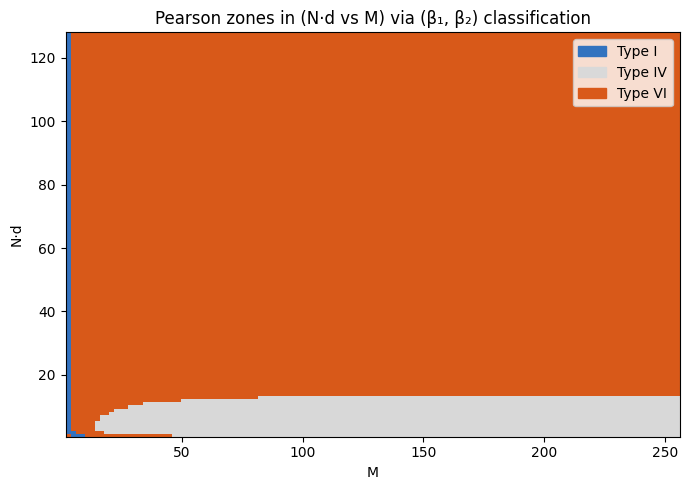

In [4]:
# --- Render figure ---
cmap = {
    1: (0.20, 0.45, 0.75),  # Type I  — blue-ish
    4: (0.85, 0.85, 0.85),  # Type IV — light grey
    6: (0.85, 0.35, 0.10),  # Type VI — orange-red
}
C = np.zeros((resNd, resM, 3))
for k, col in cmap.items():
    C[Z == k] = col

plt.figure(figsize=(7, 5))
plt.imshow(
    C,
    origin="lower",
    extent=[Mmin, Mmax, Ndmin, Ndmax],
    aspect="auto",
    interpolation="nearest",
)
plt.xlabel("M")
plt.ylabel("N·d")
plt.title("Pearson zones in (N·d vs M) via (β₁, β₂) classification")

import matplotlib.patches as mpatches
patches = [
    mpatches.Patch(color=cmap[1], label="Type I"),
    mpatches.Patch(color=cmap[4], label="Type IV"),
    mpatches.Patch(color=cmap[6], label="Type VI"),
]
plt.legend(handles=patches, loc="upper right")
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=160, bbox_inches="tight")
print("Saved", PNG_OUT)
plt.show()
